In [28]:
import os
import glob
from pathlib import Path
import warnings

import math
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

from timm.data.random_erasing import RandomErasing

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from progress import NotebookProgressCallback
import time

pl.seed_everything(42)

Global seed set to 42


42

In [3]:
warnings.filterwarnings('ignore')

In [4]:
PATH = os.getcwd()

PATH = Path(os.path.join(PATH, "data/"))

os.makedirs(PATH, exist_ok=True)
print(PATH)

/home/stud1901/image_restoration/data


In [9]:
all_images = os.listdir(PATH/"images/clean")[:7000]
train_images, valid_images = train_test_split(all_images, test_size=0.2, random_state=42)
len(train_images), len(valid_images)

(5600, 1400)

In [10]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images: list, img_size:int): 
        self._images = images
        self._path   = PATH/"images/clean"
        
        # transformations applied to add Noise to the Images
        self._transforms = A.Compose([
            A.Resize(img_size, img_size, p=1.0),
            A.ToFloat(max_value=255.0),
            ToTensorV2(p=1.0)
        ])
        
        self._erase_trasforms = A.Compose([
            A.Resize(img_size, img_size, p=1.0),
            A.CoarseDropout(max_holes=1, min_holes=1, p=1.0, max_width=50, max_height=50),
            A.ToFloat(max_value=255.0),
            ToTensorV2(p=1.0)
        ])
    
    @property
    def transforms(self):
        return self._transforms
    
    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, idx):
        image_path = self._path / self._images[idx]
        cln_img, nsy_img = str(image_path), str(image_path)
        cln_img, nsy_img = cv2.cvtColor(cv2.imread(cln_img), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(nsy_img), cv2.COLOR_BGR2RGB)
        cln_img, nsy_img = self.transforms(image=cln_img), self._erase_trasforms(image=nsy_img)
        return cln_img["image"], nsy_img['image']

In [11]:
# build datasets for training and validation
train_ds = ImageDataset(train_images, img_size=256)
valid_ds = ImageDataset(valid_images, img_size=256)

# build dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, num_workers=5, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=128, num_workers=5)

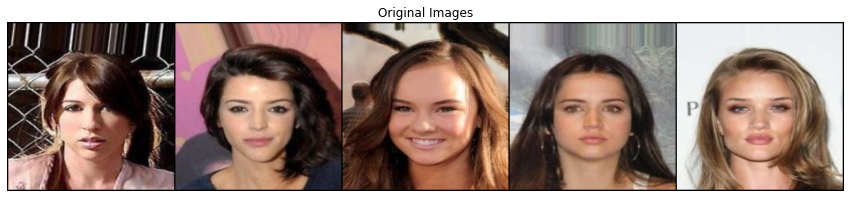

In [12]:
cln_ims, nsy_ims = next(iter(train_dl))
cln_ims, nsy_ims = cln_ims[:5], nsy_ims[:5]

grid = make_grid(cln_ims, normalize=True).permute(1, 2, 0).numpy()
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(grid)
plt.title("Original Images")
plt.pause(0.01);

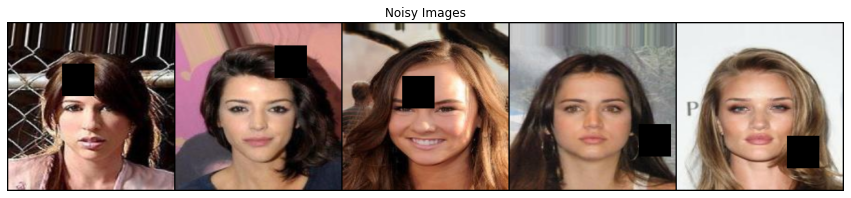

In [13]:
grid = make_grid(nsy_ims, normalize=True).permute(1, 2, 0).numpy()
plt.figure(figsize=(15, 10))
plt.axis("off")
plt.imshow(grid)
plt.title("Noisy Images")
plt.pause(0.01);

In [14]:
# cln_ims, nsy_ims = next(iter(valid_dl))
# cln_ims, nsy_ims = cln_ims[:5], nsy_ims[:5]

# grid = make_grid(cln_ims, normalize=True).permute(1, 2, 0).numpy()
# plt.figure(figsize=(15, 15))
# plt.axis("off")
# plt.imshow(grid)
# plt.title("Original Images")
# plt.pause(0.01);

In [141]:
class RestorationAutoEncoder(nn.Module):
    def __init__(self, num_layers=10, num_features=64):
        super(RestorationAutoEncoder, self).__init__()
        self.num_layers = num_layers

        conv_layers = []
        deconv_layers = []

        conv_layers.append(
            nn.Sequential(
                nn.Conv2d(3, num_features, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(num_features),
                nn.ReLU(inplace=True)
            )
        )
        for i in range(num_layers - 1):
            conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                    nn.BatchNorm2d(num_features),
                    nn.ReLU(inplace=True)
                )
            )

        for i in range(num_layers - 1):
            deconv_layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(num_features, num_features, kernel_size=3, padding=1),
                    nn.BatchNorm2d(num_features),
                    nn.ReLU(inplace=True)
                )
            )
        deconv_layers.append(
            nn.ConvTranspose2d(num_features, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

        self.conv_layers   = nn.Sequential(*conv_layers)
        self.deconv_layers = nn.Sequential(*deconv_layers)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        conv_feats = []
        for i in range(self.num_layers):
            x = self.conv_layers[i](x)
            if (i + 1) % 2 == 0 and len(conv_feats) < math.ceil(self.num_layers / 2) - 1:
                conv_feats.append(x)

        conv_feats_idx = 0
        for i in range(self.num_layers):
            x = self.deconv_layers[i](x)
            if (i + 1 + self.num_layers) % 2 == 0 and conv_feats_idx < len(conv_feats):
                conv_feat = conv_feats[-(conv_feats_idx + 1)]
                conv_feats_idx += 1
                x = x + conv_feat
                x = self.relu(x)

        x += residual
        x = self.relu(x)

        return x

In [142]:
class RestorationModel(pl.LightningModule):
    def __init__(self, lr: float, num_layers: int = 10, num_features:int = 64):
        super(RestorationModel, self).__init__()
        self.save_hyperparameters()
        self.model = RestorationAutoEncoder(num_layers=self.hparams.num_layers, num_features=self.hparams.num_features)
        
    def forward(self, xb):
        "forward method for nn.Module"
        return self.model(xb)
    
    def training_step(self, batch, batch_idx):
        "Computer on single training step"
        # unpack batch
        cln_ims, nsy_ims = batch 
        
        # restore images given noisy images to the model as Input
        outputs = self.forward(nsy_ims)
        
        # compare the restored images with the clean Images
        loss = F.mse_loss(input=outputs.sigmoid(), target=cln_ims)
        self.log_dict(dict(train_loss=loss), prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        cln_ims, nsy_ims = batch 
        outputs = self.forward(nsy_ims)
        loss = F.mse_loss(input=outputs.sigmoid(), target=cln_ims)
        self.log_dict(dict(valid_loss=loss), prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def configure_optimizers(self):
        "steps up the optimizer and scheduler for the experiment"
        opt = optim.Adam(self.model.parameters(), lr=self.hparams.lr)
        sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.trainer.max_epochs)
        return [opt],[sch]

In [146]:
dirpath = f"checkpoints/{str(time.time())}"
print(f"Directory: {dirpath}")

model = RestorationModel(lr=8e-04, num_layers=10, num_features=64)

cbs = [
    pl.callbacks.ModelCheckpoint(dirpath=dirpath, mode="min", monitor="valid_loss",), 
    NotebookProgressCallback(),
] 

trainer = pl.Trainer(logger=[pl.loggers.CSVLogger(save_dir=dirpath)], gpus=-1, callbacks=cbs, precision=16, max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


Directory: checkpoints/1625304212.9030375


In [147]:
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=valid_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | RestorationAutoEncoder | 670 K 
-------------------------------------------------
670 K     Trainable params
0         Non-trainable params
670 K     Total params
2.683     Total estimated model params size (MB)


Global seed set to 42


epoch,valid_loss,train_loss,time,samples/s
0,0.063241,0.062865,28.119100,1.956000
1,0.104479,0.060639,27.979000,1.965800
2,0.061802,0.060288,28.289000,1.944200
3,0.061150,0.060171,28.009000,1.963700
4,0.061128,0.060020,26.932100,2.042200
5,0.060981,0.059954,26.911400,2.043700
6,0.060935,0.059896,26.972300,2.039100
7,0.060996,0.059889,26.955900,2.040400
8,0.062067,0.059860,27.069400,2.031800
9,0.061220,0.059828,27.150300,2.025800


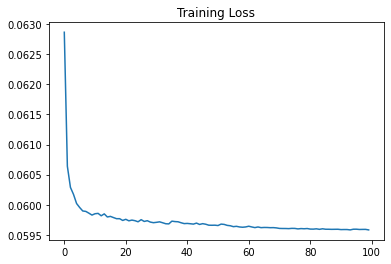

In [148]:
import pandas as pd
learning_curves = pd.read_csv(f'{dirpath}/default/version_0/metrics.csv')
train_losses = learning_curves['train_loss'].dropna().values.tolist()
plt.plot(train_losses)
plt.title('Training Loss');

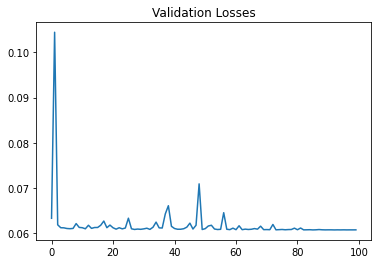

In [149]:
valid_losses = learning_curves['valid_loss'].dropna().values.tolist()
plt.plot(valid_losses)
plt.title('Validation Losses');

In [150]:
cln_ims, nsy_ims = next(iter(valid_dl))
cln_ims, nsy_ims = cln_ims[14:17], nsy_ims[14:17]

In [151]:
with torch.no_grad():
    model.eval()
    results = model.to("cpu")(nsy_ims).sigmoid()

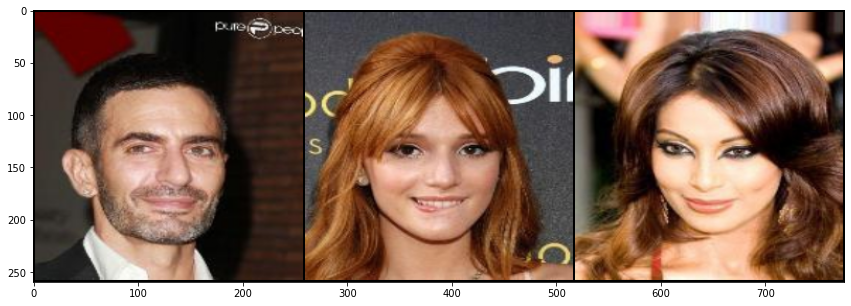

In [152]:
clean_grid = make_grid(cln_ims, normalize=True)
clean_grid = clean_grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(20, 5))
plt.imshow(clean_grid);

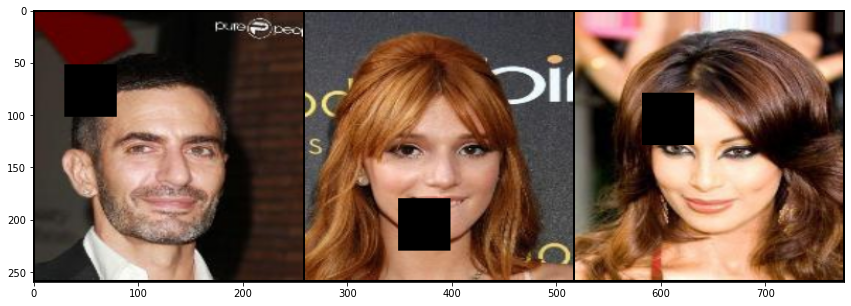

In [153]:
clean_grid = make_grid(nsy_ims, normalize=True)
clean_grid = clean_grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(20, 5))
plt.imshow(clean_grid);

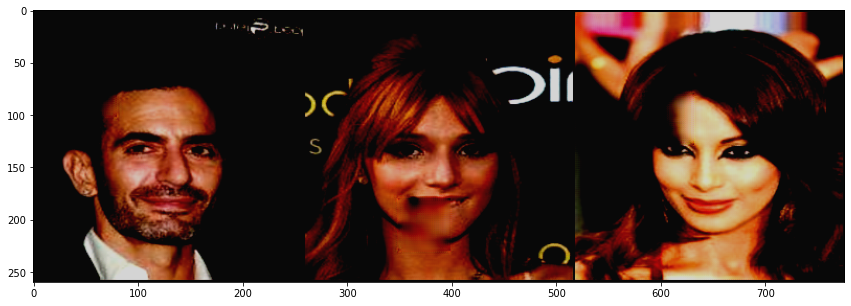

In [159]:
grid = make_grid(results[:3], normalize=True)
grid = grid.permute(1, 2, 0).cpu().numpy()
grid *= 255.0
grid = grid.astype(np.uint8)

grid = A.functional.adjust_brightness_torchvision(grid, factor=1.2)
grid = A.functional.adjust_contrast_torchvision(grid, factor=0.8)
plt.figure(figsize=(20, 5))
plt.imshow(grid);